In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from pychromatic import Multiplot
from runnerase.calculators.runner import Runner
from runnerase.utils.atoms import binary_composition

/tmp/ipykernel_3967/3248742831.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
colors = {"g": "#1b9e77", "r": "#d95f02", "b": "#7570b3"}

EAM Data

In [3]:
eam_df = pd.read_pickle('../data/867630_Test.pckl.gz')

2024-02-15 15:58:44,430 - pyiron_log - WARNING - pyiron found a 'templates' folder in the /home/menon/pyiron/resources resource directory. These are no longer supported in pyiron_base >=0.7.0. They are replaced by Project.create_job_class() and Project.wrap_python_function().


HDNNP Data

In [4]:
FIT_PATH = 'hdnnp_potential/modes'

In [7]:
full_dataset = read('input.data_all', index=':', format='runnerdata')
mode1 = Runner(restart=f'{FIT_PATH}/mode1/mode1', label='analysis/analysis', command='')
#mode2 = Runner(restart=f'{FIT_PATH}/mode2/mode2', label='analysis/analysis', command='')
mode3 = Runner(restart=f'{FIT_PATH}/mode3/mode3', label='analysis/analysis', command='')

In [8]:
analyze = mode3.analyze

In [9]:
train = mode1.results['splittraintest'].train
test = mode1.results['splittraintest'].test

energy_hdnnp = analyze.energy_per_atom_hdnnp
energy_reference = analyze.energy_per_atom_reference
forces_hdnnp = analyze.forces_hdnnp
forces_reference = analyze.forces_reference

ftrain_hdnnp = np.vstack(forces_hdnnp[train]).flatten()
ftest_hdnnp = np.vstack(forces_hdnnp[test]).flatten()
ftrain_ref = np.vstack(forces_reference[train]).flatten()
ftest_ref = np.vstack(forces_reference[test]).flatten()

ACE Data

In [10]:
ace_train_df = pd.read_pickle("ACE-8A-pred/train_pred.pckl.gzip", compression="gzip")
ace_test_df = pd.read_pickle("ACE-8A-pred/test_pred.pckl.gzip", compression="gzip")
ace_train_df["energy_pred_per_atom"]=ace_train_df["energy_pred"]/ace_train_df["NUMBER_OF_ATOMS"]
ace_test_df["energy_pred_per_atom"]=ace_test_df["energy_pred"]/ace_test_df["NUMBER_OF_ATOMS"]
ace_test_df["dEpa"]=abs(ace_test_df["energy_pred_per_atom"]-ace_test_df["energy_corrected_per_atom"])
ace_test_df=ace_test_df.query("dEpa<10") # drop structures beyond core-rep 

In [11]:
train_f_ref = np.vstack(ace_train_df["forces"]).flatten()
train_f_ace = np.vstack(ace_train_df["forces_pred"]).flatten()
test_f_ref = np.vstack(ace_test_df["forces"]).flatten()
test_f_ace = np.vstack(ace_test_df["forces_pred"]).flatten()

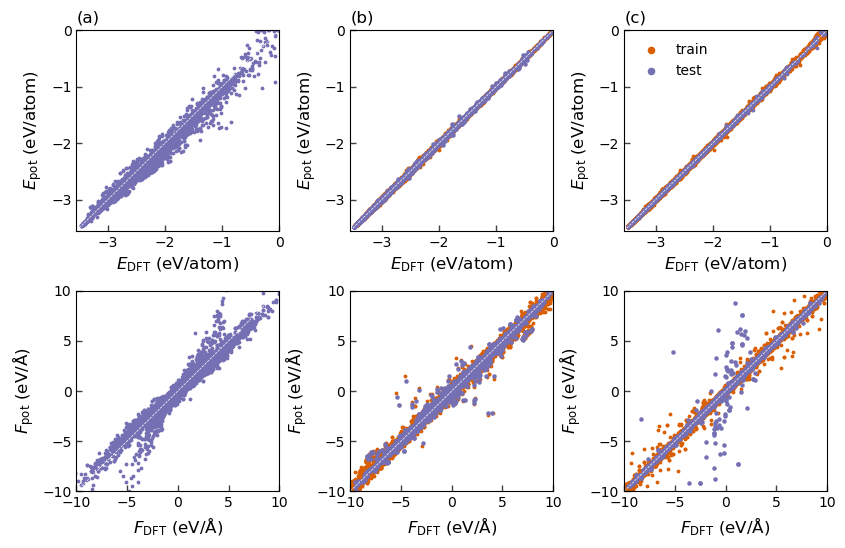

In [12]:
mlt = Multiplot(rows=2, columns=3, width=700,
               hspace=0.3, wspace=0.35)

# EAM
#----------------------------------------------
mlt[0,0].scatter(eam_df.energy/eam_df.number_of_atoms, 
                 eam_df.predicted_energy/eam_df.number_of_atoms, color=colors['b'],
                s=3)
mlt[0,0].set_xlim(-3.55,0)
mlt[0,0].set_ylim(-3.55,0)
mlt[0,0].plot([-3.55, 0], [-3.55, 0], ls="--", color='white', zorder=1, lw=0.5)
mlt[0,0].set_xlabel(r'$E_\mathrm{DFT}$ (eV/atom)', fontsize=12)
mlt[0,0].set_ylabel(r'$E_\mathrm{pot}$ (eV/atom)', fontsize=12)
mlt[0,0].set_title('(a)', loc='left', fontsize=12)

mlt[1,0].scatter(np.vstack(eam_df.forces).flatten(), 
                 np.vstack(eam_df.predicted_forces).flatten(), color=colors['b'],
                s=3)
mlt[1,0].set_xlim(-10,10)
mlt[1,0].set_ylim(-10,10)
mlt[1,0].plot([-10, 10], [-10, 10], ls="--", color='white',zorder=1, lw=0.5)
mlt[1,0].set_xlabel(r'$F_\mathrm{DFT}$ (eV/$\mathrm{\AA}$)', fontsize=12)
mlt[1,0].set_ylabel(r'$F_\mathrm{pot}$ (eV/$\mathrm{\AA}$)', fontsize=12)
#mlt[1,0].set_title('(b)', loc='left', fontsize=12)

# HDNNP
#----------------------------------------------
mlt[0,1].scatter(energy_reference[train], 
                 energy_hdnnp[train], 
                 label='Train', s=3, c=colors['r'])
mlt[0,1].scatter(energy_reference[test], 
                 energy_hdnnp[test], 
                 label='Test', s=5, c=colors['b'])
mlt[0,1].plot([-3.55, 0], [-3.55, 0], ls="--", color='white', zorder=1, lw=0.5)
mlt[0,1].set_xlim(-3.55,0)
mlt[0,1].set_ylim(-3.55,0)
mlt[0,1].set_xlabel(r'$E_\mathrm{DFT}$ (eV/atom)', fontsize=12)
mlt[0,1].set_ylabel(r'$E_\mathrm{pot}$ (eV/atom)', fontsize=12)
mlt[0,1].set_title('(b)', loc='left', fontsize=12)

mlt[1,1].scatter(ftrain_ref, ftrain_hdnnp, 
                 label='Train', s=3, 
                 c=colors['r'])
mlt[1,1].scatter(ftest_ref, ftest_hdnnp, 
                 label='Test', s=5, 
                 c=colors['b'])
mlt[1,1].set_xlim(-10,10)
mlt[1,1].set_ylim(-10,10)
mlt[1,1].plot([-10, 10], [-10, 10], ls="--", color='white',zorder=1, lw=0.5)
mlt[1,1].set_xlabel(r'$F_\mathrm{DFT}$ (eV/$\mathrm{\AA}$)', fontsize=12)
mlt[1,1].set_ylabel(r'$F_\mathrm{pot}$ (eV/$\mathrm{\AA}$)', fontsize=12)
#mlt[1,1].set_title('(d)', loc='left', fontsize=12)

# TEST
#----------------------------------------------
mlt[0,2].scatter(ace_train_df["energy_corrected_per_atom"],
                 ace_train_df["energy_pred_per_atom"],s=3, 
                 color=colors['r'])
mlt[0,2].scatter(ace_test_df["energy_corrected_per_atom"],
                 ace_test_df["energy_pred_per_atom"],s=3, 
                 color=colors['b'])

mlt[0,2].set_xlim(-3.55,0)
mlt[0,2].set_ylim(-3.55,0)

mlt[0,2].plot([-3.55, 0], [-3.55, 0], ls="--", color='white', zorder=1, lw=0.5)
mlt[0,2].set_xlabel(r'$E_\mathrm{DFT}$ (eV/atom)', fontsize=12)
mlt[0,2].set_ylabel(r'$E_\mathrm{pot}$ (eV/atom)', fontsize=12)
mlt[0,2].set_title('(c)', loc='left', fontsize=12)
mlt[0,2].scatter([],[], s=20, color=colors['r'], label='train')
mlt[0,2].scatter([],[], s=20, color=colors['b'], label='test')
mlt[0,2].legend(frameon=False)

mlt[1,2].scatter(train_f_ref, train_f_ace, s=3, 
                 label="Train", color=colors['r'])
mlt[1,2].scatter(test_f_ref, test_f_ace  ,s=5, 
                 label='Test', color=colors['b'])

mlt[1,2].set_xlim(-10,10)
mlt[1,2].set_ylim(-10,10)
mlt[1,2].plot([-10, 10], [-10, 10], ls="--", color='white',zorder=1, lw=0.5)
mlt[1,2].set_xlabel(r'$F_\mathrm{DFT}$ (eV/$\mathrm{\AA}$)', fontsize=12)
mlt[1,2].set_ylabel(r'$F_\mathrm{pot}$ (eV/$\mathrm{\AA}$)', fontsize=12)
#mlt[1,2].set_title('(f)', loc='left', fontsize=12)
plt.savefig("energy_force.png", dpi=300, bbox_inches="tight")